In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pathlib

In [ ]:
input_ = tf.keras.layers.Input(shape=(224, 224, 1), name="INPUT")
normalization = tf.keras.layers.Rescaling(1./255)(input_) # Standardize the data
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, activation="relu", name="CONV1")(normalization) 
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL1")(conv1) 
conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, activation="relu", name="CONV2")(pool1)
concat1 = tf.keras.layers.Concatenate()([pool1, conv2])

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL2")(concat1)
conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, activation="relu", name="CONV3")(pool2)
concat2 = tf.keras.layers.Concatenate()([pool2, conv3])

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL3")(concat2)
conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, activation="relu", name="CONV4")(pool3)
concat3 = tf.keras.layers.Concatenate()([pool3, conv4])

pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="POOL4")(concat3)
flatten = tf.keras.layers.Flatten()(pool4)
fc1 = tf.keras.layers.Dense(4096, activation='relu')(flatten)
fc2 = tf.keras.layers.Dense(2048, activation='relu')(fc1)

output = tf.keras.layers.Dense(7, activation='softmax')(fc2)

model = tf.keras.Model(
    inputs=[input_],
    outputs=[output]
)

Load in / prep the data

In [15]:
train_dir = pathlib.Path("Train").with_suffix('')
test_dir = pathlib.Path("Test").with_suffix('')

In [16]:
print(f"Number of images for training/val: {len(list(train_dir.glob('*/*.jpg')))}")
print(f"NUmber of images for testing: {len(list(test_dir.glob('*/*.jpg')))}") 

Number of images for training/val: 2093
NUmber of images for testing: 639


In [ ]:
# Display an image
angry = list(train_dir.glob('Angry/*'))
Image.open(str(angry[0]))

In [24]:
# Check how many samples fall into each emotion category
print("Number of samples in each emotion category in the Train/Val set")
for e in ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]:
    print(f"Emotion:{e}, # Samples:{len(list(train_dir.glob(f'{e}/*')))}")

Number of samples in each emotion category in the Train/Val set
Emotion:Angry, # Samples:327
Emotion:Disgust, # Samples:132
Emotion:Fear, # Samples:339
Emotion:Happy, # Samples:292
Emotion:Neutral, # Samples:320
Emotion:Sad, # Samples:332
Emotion:Surprise, # Samples:283


In [25]:
# Convert images to format compatible with TF

im_size = (224, 224)
val_split = 0.1
batch_size = 32
seed = 11
mode = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=(im_size),
    batch_size=batch_size,
    color_mode=mode
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=im_size,
    batch_size=batch_size,
    color_mode=mode
)

Found 2025 files belonging to 7 classes.
Using 1823 files for training.
Found 2025 files belonging to 7 classes.
Using 202 files for validation.
Found 799 files belonging to 7 classes.


In [26]:
model.compile( 
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=(val_ds)
)

Epoch 1/5


57/57 [==============================] - 180s 3s/step - loss: 4.2401 - accuracy: 0.1569 - val_loss: 1.9280 - val_accuracy: 0.2178
Epoch 2/5
57/57 [==============================] - 174s 3s/step - loss: 1.8917 - accuracy: 0.1931 - val_loss: 1.8951 - val_accuracy: 0.2129
Epoch 3/5
57/57 [==============================] - 159s 3s/step - loss: 1.8481 - accuracy: 0.2244 - val_loss: 1.8866 - val_accuracy: 0.2277
Epoch 4/5
57/57 [==============================] - 166s 3s/step - loss: 1.7745 - accuracy: 0.2644 - val_loss: 1.8088 - val_accuracy: 0.2624
Epoch 5/5
57/57 [==============================] - 164s 3s/step - loss: 1.7069 - accuracy: 0.3055 - val_loss: 1.8208 - val_accuracy: 0.3119


Make Predictions

In [ ]:
predicted = []
actual = []

for images, labels in test_ds:
    probabilities = model.predict(images)

    for pred in probabilities:
        predicted.append(np.argmax(pred))
    
    for l in labels:
        actual.append(l)

In [ ]:
expressions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

for i in range(len(actual)):
    print(f"Actual={expressions[actual[i].numpy()]}, Predicted={expressions[predicted[i]]}")

Confusion Matrix

In [30]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [37]:
array = tf.math.confusion_matrix(labels=actual, predictions=predicted)

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(95.72222222222221, 0.5, 'Actual')]

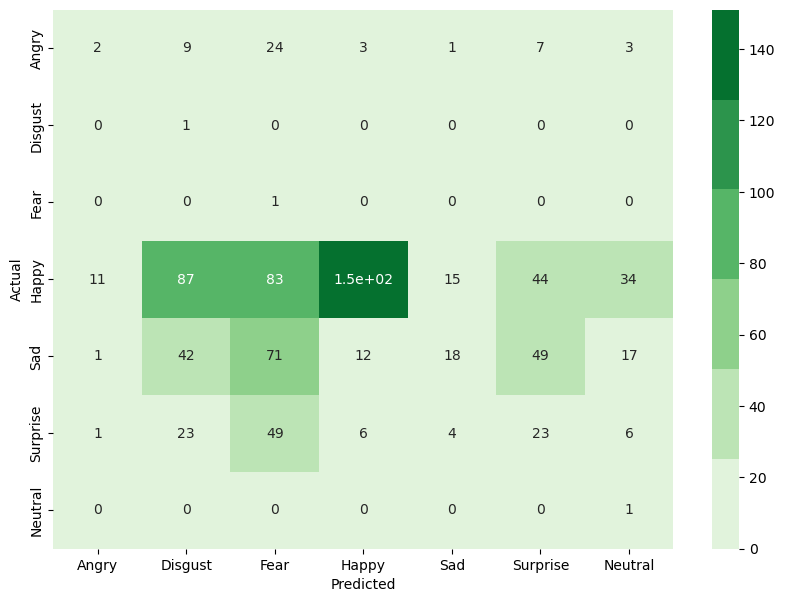

In [62]:
plt.figure(figsize=(10,7))
l = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
sns.heatmap(array, annot=True, cmap=sns.color_palette("Greens"), xticklabels=l, yticklabels=l).set(xlabel="Predicted", ylabel="Actual")

Model Metrics

In [39]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [45]:
print(f"F1-Score:   {dict( zip( l, f1_score(actual, predicted, average=None) ) )}")
print(f"Accuracy:   {accuracy_score(actual, predicted)}")
print(f"Precision:  {dict( zip( l, precision_score(actual, predicted, average=None) ) )}")
print(f"Recall:     {dict( zip( l, recall_score(actual, predicted, average=None) ) )}")

F1-Score:   {'Angry': 0.0625, 'Disgust': 0.012269938650306749, 'Fear': 0.008733624454148471, 'Happy': 0.5058626465661642, 'Sad': 0.14516129032258066, 'Surprise': 0.19574468085106383, 'Neutral': 0.03225806451612903}
Accuracy:   0.246558197747184
Precision:  {'Angry': 0.13333333333333333, 'Disgust': 0.006172839506172839, 'Fear': 0.0043859649122807015, 'Happy': 0.877906976744186, 'Sad': 0.47368421052631576, 'Surprise': 0.18699186991869918, 'Neutral': 0.01639344262295082}
Recall:     {'Angry': 0.04081632653061224, 'Disgust': 1.0, 'Fear': 1.0, 'Happy': 0.3552941176470588, 'Sad': 0.08571428571428572, 'Surprise': 0.20535714285714285, 'Neutral': 1.0}
